<a href="https://colab.research.google.com/github/knightda/Firmware/blob/master/Copy_of_Detectron2_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and play with it yourself. __DO NOT__ request access to this tutorial.


# Install detectron2

In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8MB 26kB/s 
     |████████████████████████████████| 6.6MB 24.8MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101
     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=d36dfa34254387385dcf9259737ad9fffd29fefb783a7b7c693b16ccd4cc8298
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip

In [2]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 857kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200623-cp36-none-any.whl size=41183 sha256=8ea4983f004b1f4cbc8022e50b6de0565212f91c242c5ec304b5507de9c52bad
  Stored in directory: /root/.cache/pip/wheels/31/b5/a9/df0fd43b263cc96c1d5076ade63fdcdd30fab8699e3366a60c
Successfully built fvcore


In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Run a pre-trained detectron2 model

We first download a random image from the COCO dataset:

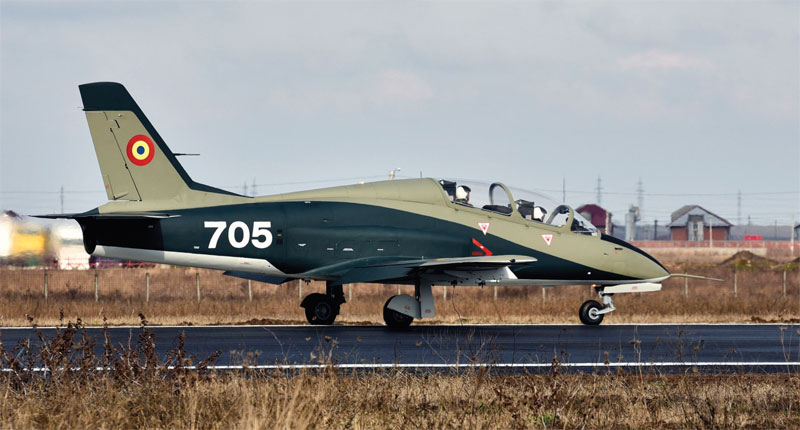

In [5]:
im = cv2.imread("./iar99_02.jpg")
cv2_imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [6]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [7]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([4, 0], device='cuda:0')
Boxes(tensor([[ 14.9557,  81.0237, 682.7068, 329.9685],
        [455.7064, 184.7804, 473.0129, 206.2979]], device='cuda:0'))


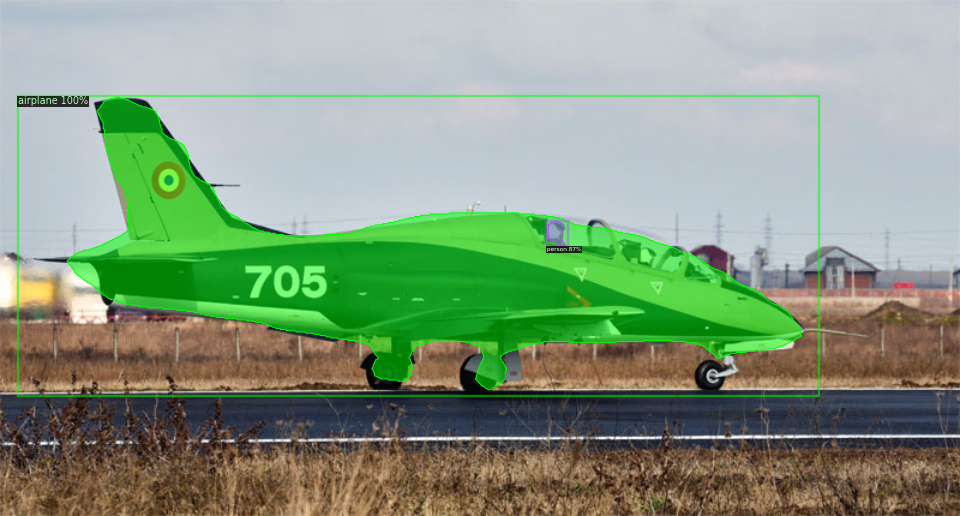

In [8]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the balloon segmentation dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon)
which only has one class: balloon.
We'll train a balloon segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "balloon" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

In [2]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("zona_rugina_data_", {}, "/content/trainval.json", "/content/imagini")


## Train!

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [27]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("zona_rugina_data_",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/23 17:42:43 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (1,) in the model!


[06/23 17:42:44 d2.engine.train_loop]: Starting training from iteration 0
[06/23 17:43:13 d2.utils.events]:  eta: 0:48:51  iter: 19  total_loss: 5.857  loss_cls: 0.611  loss_box_reg: 0.632  loss_mask: 0.697  loss_rpn_cls: 3.585  loss_rpn_loc: 0.309  time: 1.4906  data_time: 0.0189  lr: 0.000005  max_mem: 3226M
[06/23 17:43:42 d2.utils.events]:  eta: 0:47:33  iter: 39  total_loss: 4.136  loss_cls: 0.574  loss_box_reg: 0.641  loss_mask: 0.692  loss_rpn_cls: 1.959  loss_rpn_loc: 0.286  time: 1.4596  data_time: 0.0066  lr: 0.000010  max_mem: 3226M
[06/23 17:44:10 d2.utils.events]:  eta: 0:46:44  iter: 59  total_loss: 2.727  loss_cls: 0.518  loss_box_reg: 0.602  loss_mask: 0.684  loss_rpn_cls: 0.625  loss_rpn_loc: 0.276  time: 1.4373  data_time: 0.0068  lr: 0.000015  max_mem: 3226M
[06/23 17:44:37 d2.utils.events]:  eta: 0:45:37  iter: 79  total_loss: 2.172  loss_cls: 0.476  loss_box_reg: 0.577  loss_mask: 0.673  loss_rpn_cls: 0.178  loss_rpn_loc: 0.250  time: 1.4217  data_time: 0.0064  lr:

In [28]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 1608), started 2:49:57 ago. (Use '!kill 1608' to kill it.)

<IPython.core.display.Javascript object>

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [29]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("zona_rugina_test", )
predictor = DefaultPredictor(cfg)


Then, we randomly select several samples to visualize the prediction results.

WARNING [06/23 18:33:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/23 18:33:26 d2.data.datasets.coco]: Loaded 10 images in COCO format from /content/trainval.json


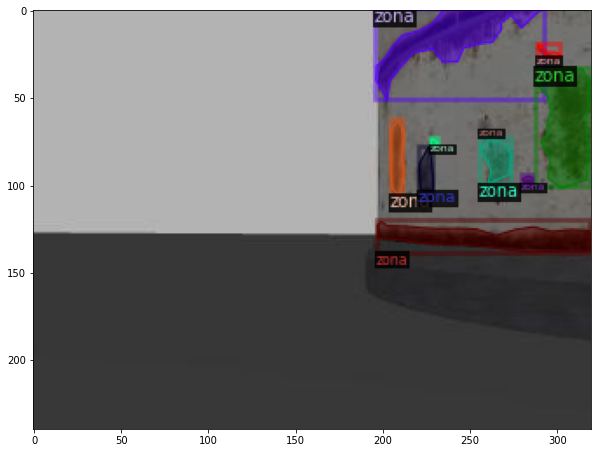

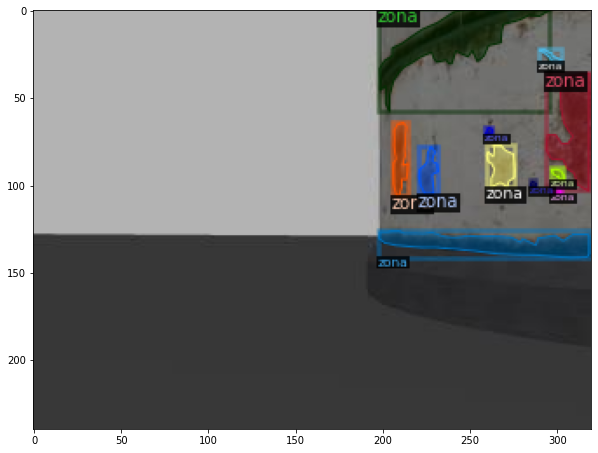

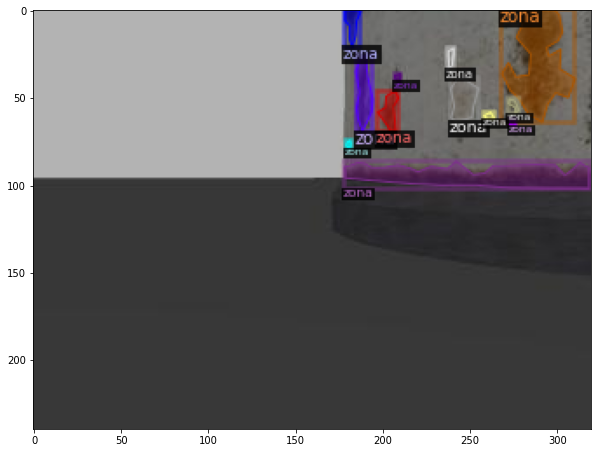

In [30]:
from detectron2.utils.visualizer import ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog
import matplotlib.pyplot as plt

dataset_dicts = DatasetCatalog.get("zona_rugina_data_")
zona_rugina_metadata = MetadataCatalog.get("zona_rugina_data_")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=zona_rugina_metadata)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (10, 9))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

WARNING [06/23 18:33:33 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/23 18:33:33 d2.data.datasets.coco]: Loaded 10 images in COCO format from /content/trainval.json


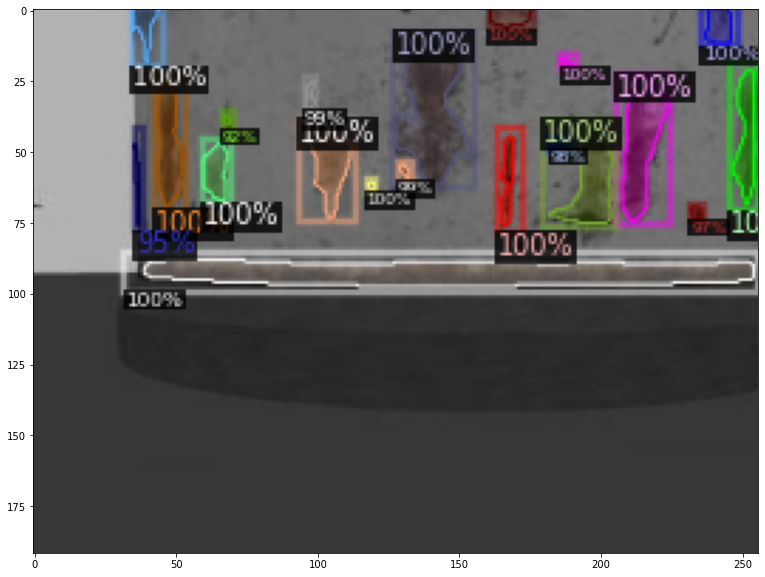

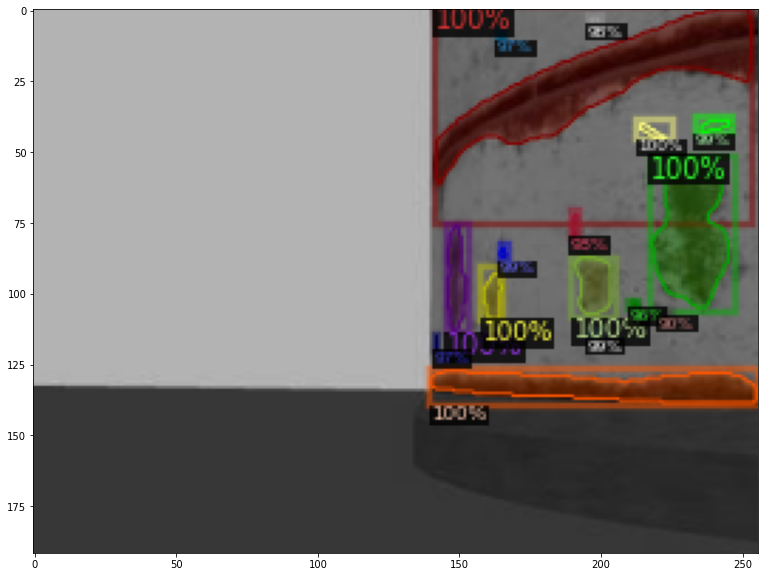

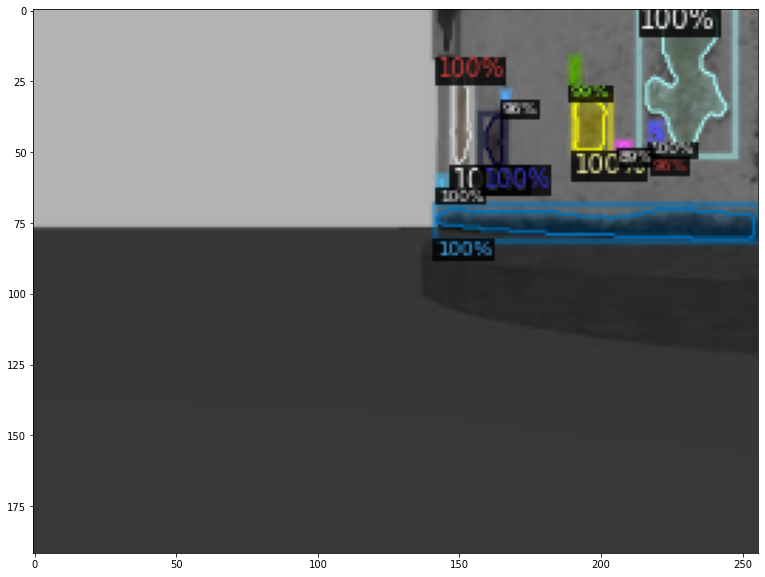

In [31]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = DatasetCatalog.get("zona_rugina_data_")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=zona_rugina_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()


We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70%. Not bad!

In [17]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("zona_rugina_data_", cfg, False, output_dir="/content/out")
val_loader = build_detection_test_loader(cfg, "zona_rugina_data_")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [06/23 17:32:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/23 17:32:37 d2.data.datasets.coco]: Loaded 10 images in COCO format from /content/trainval.json
[06/23 17:32:37 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[06/23 17:32:37 d2.data.common]: Serialized dataset takes 0.04 MiB
[06/23 17:32:37 d2.evaluation.evaluator]: Start inference on 10 images
[06/23 17:32:40 d2.evaluation.evaluator]: Total inference time: 0:00:01.760208 (0.352042 s / img per device, on 1 devices)
[06/23 17:32:40 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (0.334143 s / img per device, on 1 devices)
[06/23 17:32:41 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/23 17:32:41 d2.evaluation.coco_evaluation]: Saving results to /content/out/coco_instances_results.json
[06/23 17:32:41 d2.evaluation.coco_evaluation]: Evaluating predictions ...


OrderedDict([('bbox',
              {'AP': 67.42653557010719,
               'AP50': 95.86221601556178,
               'AP75': 75.02076719834744,
               'APl': nan,
               'APm': 88.35247173930925,
               'APs': 61.85988202035312}),
             ('segm',
              {'AP': 50.678591466450065,
               'AP50': 94.68627633866407,
               'AP75': 49.592594280245564,
               'APl': nan,
               'APm': 69.81802922195054,
               'APs': 45.338966304863945})])

# Other types of builtin models

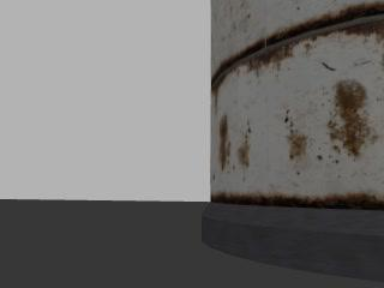

In [18]:
# Inference with a keypoint detection model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

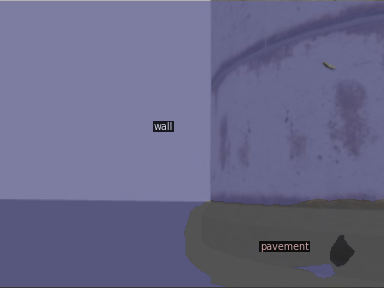

In [19]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])

# Run panoptic segmentation on a video

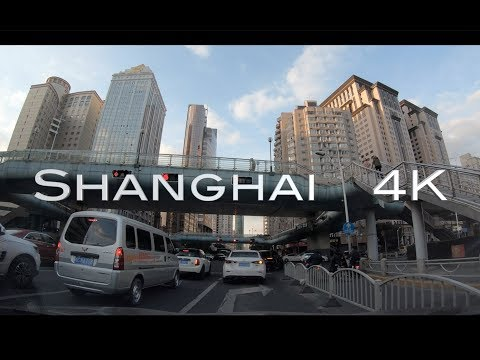

In [32]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("ll8TgCZ0plk", width=500)
display(video)

In [31]:
# Install dependencies, download the video, and crop 5 seconds for processing
!pip install youtube-dl
!pip uninstall -y opencv-python opencv-contrib-python
!apt install python3-opencv  # the one pre-installed have some issues
!youtube-dl https://www.youtube.com/watch?v=ll8TgCZ0plk -f 22 -o video.mp4
!ffmpeg -i video.mp4 -t 00:00:06 -c:v copy video-clip.mp4

     |████████████████████████████████| 1.8MB 2.7MB/s 
Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
Uninstalling opencv-contrib-python-4.1.2.30:
  Successfully uninstalled opencv-contrib-python-4.1.2.30
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  python3-opencv
0 upgraded, 1 newly installed, 0 to remove and 59 not upgraded.
Need to get 534 kB of archives.
After this operation, 2,941 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 python3-opencv amd64 3.2.0+dfsg-4ubuntu0.1 [534 kB]
Fetched 534 kB in 2s (276 kB/s)
Selecting previously unselected package python3-opencv.
(Reading database ... 144328 files and directories currently installed.)
Preparing to 

In [20]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes)
# Using a model trained on COCO dataset
!git clone https://github.com/facebookresearch/detectron2
!python detectron2/demo/demo.py --config-file detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input video-clip.mp4 --confidence-threshold 0.6 --output video-output.mkv \
  --opts MODEL.WEIGHTS ../content/output/model_final.pth detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl

fatal: destination path 'detectron2' already exists and is not an empty directory.
Failed to load OpenCL runtime
[06/23 17:36:28 detectron2]: Arguments: Namespace(confidence_threshold=0.6, config_file='detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml', input=None, opts=['MODEL.WEIGHTS', '../content/output/model_final.pth', 'detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl'], output='video-output.mkv', video_input='video-clip.mp4', webcam=False)
Traceback (most recent call last):
  File "detectron2/demo/demo.py", line 77, in <module>
    cfg = setup_cfg(args)
  File "detectron2/demo/demo.py", line 24, in setup_cfg
    cfg.merge_from_list(args.opts)
  File "/usr/local/lib/python3.6/dist-packages/fvcore/common/config.py", line 131, in merge_from_list
    return super().merge_from_list(cfg_list)
  File "/usr/local/lib/python3.6/dist-packages/yacs/config.py", line 226, in merge_from_list
    cfg_list
  File "/usr/local/lib/

In [ ]:
# Download the results
from google.colab import files
files.download('video-output.mkv')